In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [ ]:
np.random.seed(1337)
random.seed(1337)

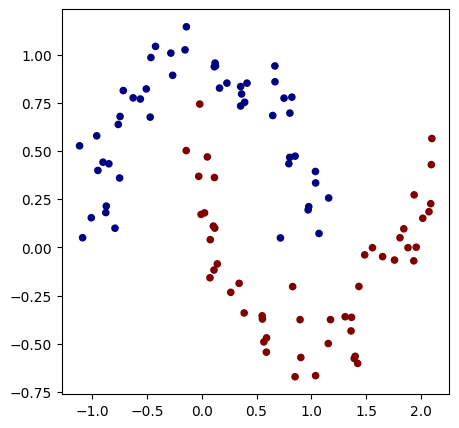

In [31]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [32]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [33]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.6014126366834882, grad=0) 0.2


In [35]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.6014126366834882, accuracy 20.0%
step 1 loss 0.7058862570587541, accuracy 78.0%
step 2 loss 1.18691339140208, accuracy 56.99999999999999%
step 3 loss 2.876164921788411, accuracy 50.0%
step 4 loss 0.7223567371921218, accuracy 72.0%
step 5 loss 0.6762769423908449, accuracy 77.0%
step 6 loss 0.39849322752335764, accuracy 83.0%
step 7 loss 0.34236865594293636, accuracy 85.0%
step 8 loss 0.31820225611566444, accuracy 86.0%
step 9 loss 0.29678978102104353, accuracy 85.0%
step 10 loss 0.29554786089452634, accuracy 89.0%
step 11 loss 0.3510259583020013, accuracy 86.0%
step 12 loss 0.2732088713536716, accuracy 87.0%
step 13 loss 0.23692383664977937, accuracy 91.0%
step 14 loss 0.2242180594093137, accuracy 91.0%
step 15 loss 0.3327327205428368, accuracy 87.0%
step 16 loss 0.3399250304654617, accuracy 89.0%
step 17 loss 0.2853226122055988, accuracy 86.0%
step 18 loss 0.2270114564533598, accuracy 90.0%
step 19 loss 0.18883040945495505, accuracy 92.0%
step 20 loss 0.16454877677609914,

(-1.6708631651078416, 2.079136834892158)

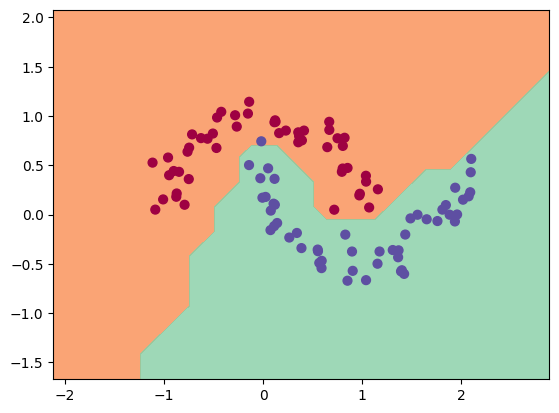

In [36]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
